In [125]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append('../.')
import datasets

In [126]:
sample_size = 200
feature_dimension = 50
# Sample wise double descent for linear model only affected by input Dimension, even if some of input is disturbance (useless) term
used_feature = feature_dimension
noise_level = 0
bias = 0
y_dimension = 1
test_size = 0.5
# set a random seed (int) if you want to the datasets to be fixed
RAND_ST = None

X, y = datasets.linear_regression_with_gaussian(sample_size=sample_size, feautre_size=feature_dimension, used_feature=used_feature, noise_level=noise_level, bias=bias, y_dimension=y_dimension, random_state=RAND_ST)
X = np.column_stack((np.ones(sample_size), X))
weight = np.random.random((X.shape[1], y_dimension))
y = 1 / (1 + np.exp(-1 * X.dot(weight)))
y[y >= 0.5] = 1
y[y < 0.5] = 0
y = y.reshape(sample_size)


# For polynominal experiment
# X = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False).fit_transform(X)
# weight = np.random.random((X.shape[1], y_dimension))
# y = X.dot(weight)

(200, 51)
(200,)


Noiseless Data

In [127]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [128]:
class logistic_regression_dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).to(torch.float32).to(device)
        self.y = torch.from_numpy(y).to(torch.float32).to(device)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        return x, y

In [129]:
class logistic_regression(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(X.shape[1], y_dimension, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.linear(x)

In [130]:
lr = 0.01
max_epoch = 10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RAND_ST, shuffle=True)
train_dataset = logistic_regression_dataset(X_train, y_train)
test_dataset = logistic_regression_dataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)

In [131]:
def train_model():
    # loss function type
    loss_fn = nn.MSELoss()
    # model
    logistic_model = logistic_regression().to(device)
    logistic_model# optimizer type
    optimizer = torch.optim.SGD(logistic_model.parameters(), lr=lr)
    
    epochs = max_epoch
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            loss_fn(logistic_model(x), y).backward()
            optimizer.step()
    
    total_train_loss = 0
    total_test_loss = 0
    with torch.no_grad():
        logistic_model.eval()
        
        for x, y in train_loader:
            total_test_loss += loss_fn(logistic_model(x), y)
        
        for x, y in test_loader:
            total_test_loss += loss_fn(logistic_model(x), y)
    
    train_loss = total_train_loss / len(train_loader)
    test_loss = total_test_loss / len(test_loader)

    return train_loss, test_loss

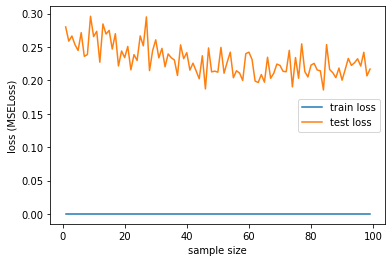

In [132]:
train_losses = []
test_losses = []

samples = [sample for sample in range(1, int(sample_size/2), 1)]

for sample in samples:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RAND_ST, shuffle=True)
    train_dataset = logistic_regression_dataset(X_train[:sample], y_train[:sample])
    test_dataset = logistic_regression_dataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=1)
    test_loader = DataLoader(test_dataset, batch_size=1)
    
    train_loss, test_loss = train_model()
    train_losses.append(float(train_loss))
    test_losses.append(float(test_loss))
    
    # print(float(train_loss))
    # print(float(test_loss))
    # print(sample)
    # print()

plt.xlabel("sample size")
plt.ylabel("loss (MSELoss)")
plt.plot(samples, train_losses, label = "train loss")
plt.plot(samples, test_losses, label = "test loss")
plt.legend()
plt.show()

Noisy Data

In [133]:
X = X + np.random.normal(0, 0.1, (sample_size, X.shape[1]))

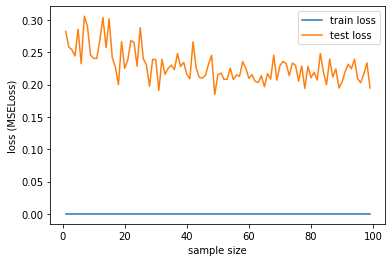

: 

In [134]:
train_losses = []
test_losses = []

samples = [sample for sample in range(1, int(sample_size/2), 1)]

for sample in samples:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RAND_ST, shuffle=True)
    train_dataset = logistic_regression_dataset(X_train[:sample], y_train[:sample])
    test_dataset = logistic_regression_dataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=1)
    test_loader = DataLoader(test_dataset, batch_size=1)
    
    train_loss, test_loss = train_model()
    train_losses.append(float(train_loss))
    test_losses.append(float(test_loss))
    
    # print(float(train_loss))
    # print(float(test_loss))
    # print(sample)
    # print()

plt.xlabel("sample size")
plt.ylabel("loss (MSELoss)")
plt.plot(samples, train_losses, label = "train loss")
plt.plot(samples, test_losses, label = "test loss")
plt.legend()
plt.show()